In [1]:
import response_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 12]

%load_ext autoreload
%autoreload 2

### 2D ODE: $\frac{\partial T(x,t)}{\partial{t}} = -k(x) T(x,t) + F(t)$

In [2]:
# Setup problem parameters
dt = 0.1
t = np.arange(0,30,dt)
dx = 1
x = np.arange(dx,11,dx)[:, np.newaxis]
T0 = 10
k = 0.25
F0 = 0.5

T_none = response_utils.T_none(t, T0, k, dim=2, x=x)
F_none = response_utils.F_none(t)
g_none, a_none = response_utils.calc_modes_2D(T_none)

T_const = response_utils.T_const(t, T0, k, F0, dim=2, x=x)
F_const = response_utils.F_const(t, F0)
g_const, a_const = response_utils.calc_modes_2D(T_const)

T_sin = response_utils.T_sin(t, T0, k, F0, dim=2, x=x)
F_sin = response_utils.F_sin(t, F0)
g_sin, a_sin = response_utils.calc_modes_2D(T_sin)

g_const_sub, a_const_sub = response_utils.calc_modes_2D(T_const - T_none,)
g_sin_sub, a_sin_sub = response_utils.calc_modes_2D(T_sin - T_none)

#### Method 1: Direct inference of L from a dataset

Error from raw estimation.
	L2 Error, F_none: 3.2284
	L2 Error, F_const: 3.11214
	L2 Error, F_sin: 3.59933
Avg. L2 Error: 3.31329

Error from modal estimation.
	L2 Error, F_none: 3.22841
	L2 Error, F_const: 3.11215
	L2 Error, F_sin: 3.59934
Avg. L2 Error: 3.3133



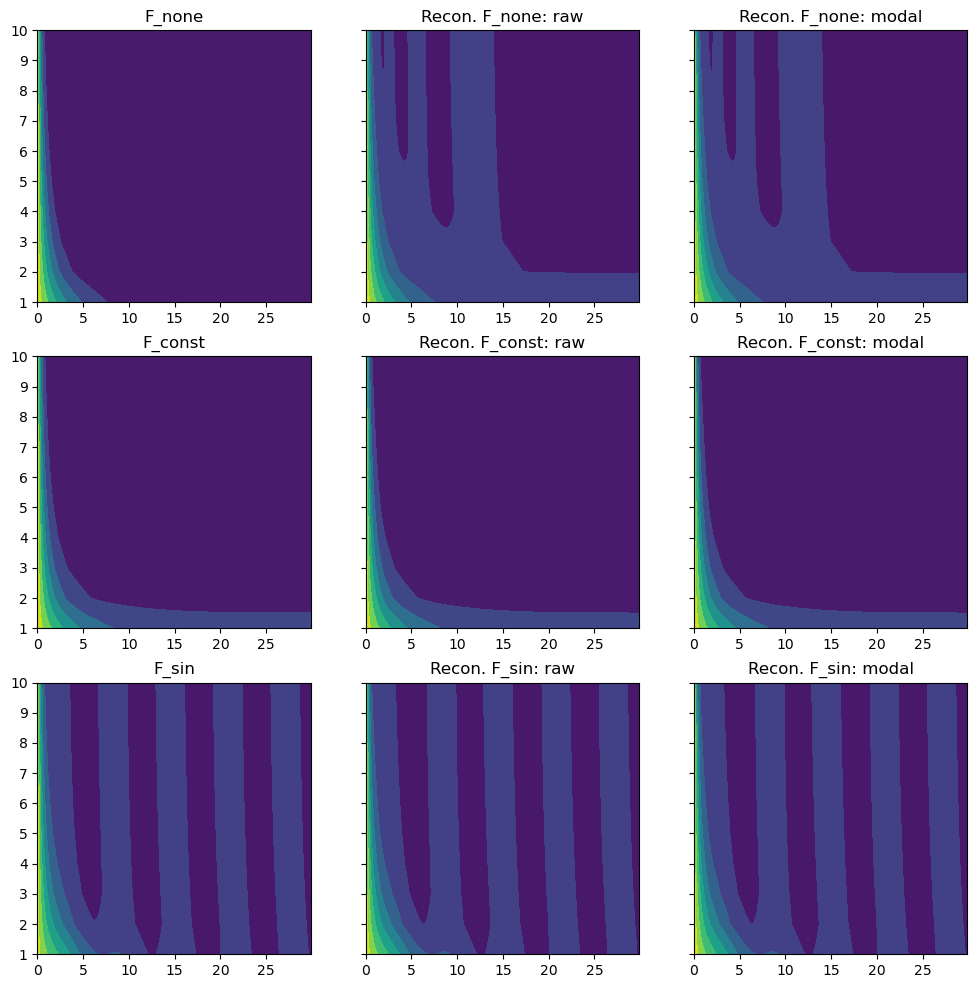

In [3]:
T_vec = [T_none, T_const, T_sin]
F_vec = [F_none, F_const, F_sin]
labels = ['F_none', 'F_const', 'F_sin']

# Calculate L
L_raw = response_utils.calc_L_direct_2D(T_none, F_none, t)
L_modal = response_utils.calc_L_direct_2D(a_none, F_none, t, modal=True, g=g_none)
L2_raw, L2_modal = response_utils.plot_response_2D(T_vec, F_vec, labels, t, x, L_raw, L_modal, T0, dt)

### Method 2: Direct derivation of response functions using an impulse forcing

Error from raw estimation.
	L2 Error, F_const: 0.20526
	L2 Error, F_sin: 2.7708
Avg. L2 Error: 1.48803

Error from modal estimation.
	L2 Error, F_const: 0.20526
	L2 Error, F_sin: 2.7708
Avg. L2 Error: 1.48803



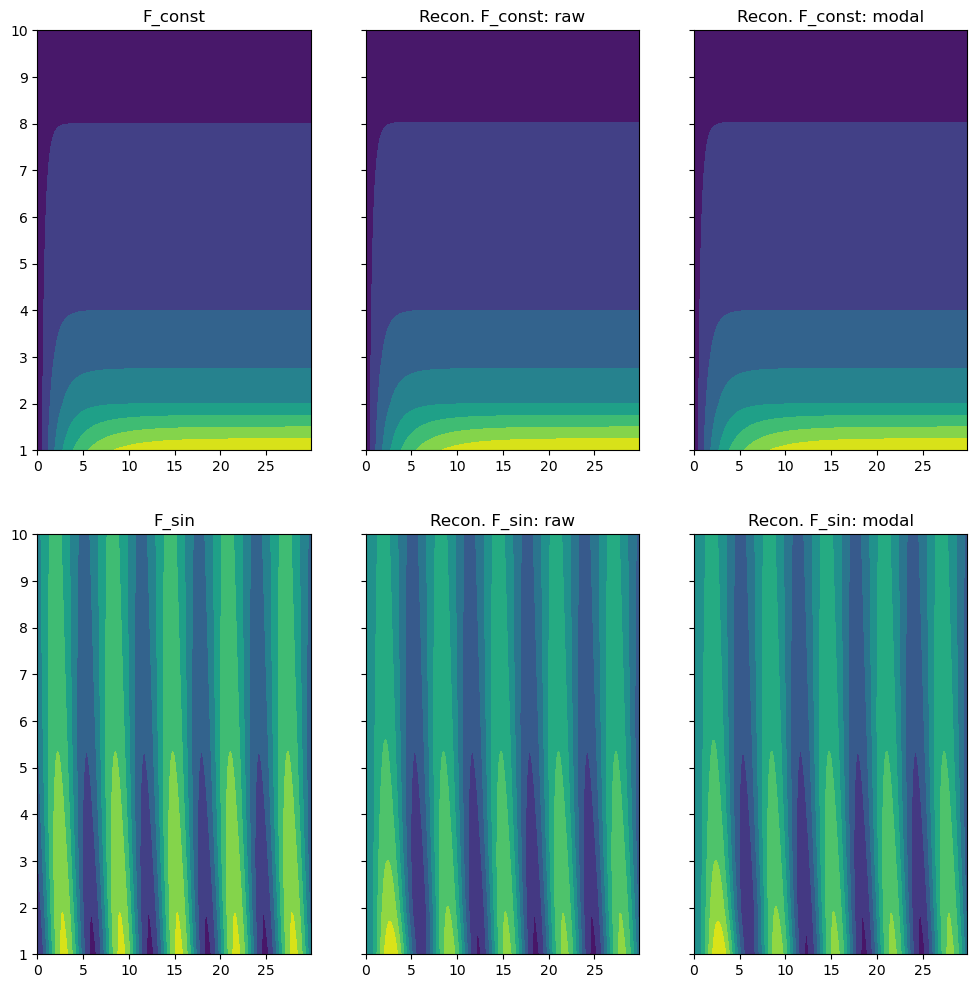

In [5]:
G_raw = response_utils.T_del(t, k, F0, dim=2, x=x)
g, G_modal = response_utils.calc_modes_2D(G_raw)
L2_raw, L2_modal = response_utils.plot_response_conv_2D(T_vec, F_vec, labels, t, x, G_raw, G_modal, g, dt)

### Method 3: Derivation through deconvolution

Error from raw estimation.
	L2 Error, F_const: 0.0
	L2 Error, F_sin: 2.78448
Avg. L2 Error: 1.39224

Error from modal estimation.
	L2 Error, F_const: 0.0
	L2 Error, F_sin: 2.78448
Avg. L2 Error: 1.39224



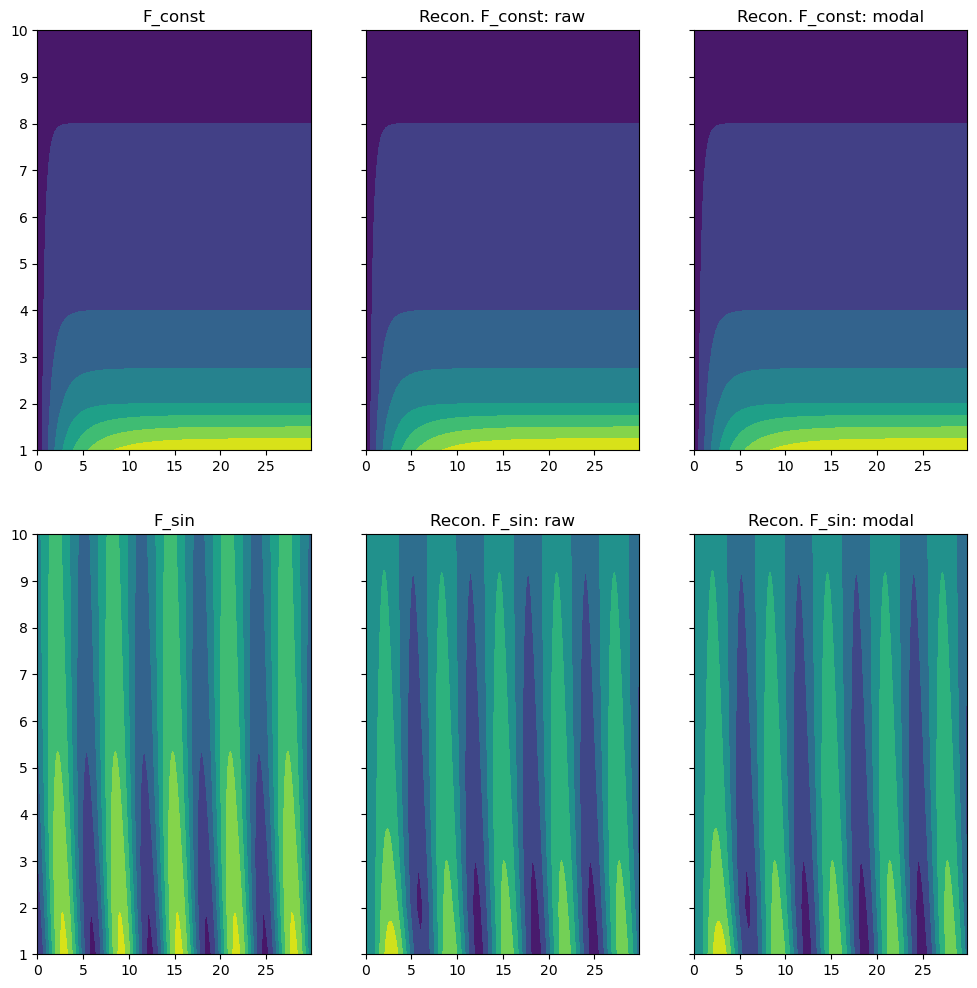

In [139]:
G_raw = response_utils.calc_G_deconv_2D(T_const - T_none, F_const, dt)
G_modal = response_utils.calc_G_deconv_2D(a_const_sub, F_const, dt)
L2_raw, L2_modal = response_utils.plot_response_conv_2D(T_vec, F_vec, labels, t, x, G_raw, G_modal, g_const_sub, dt)

### Method 4: Representing G with only leading timescales

In [16]:
print(a_const[1])

[-14.49966396 -11.38426948  -8.82164358  -6.71125395  -4.97153255
  -3.53619017  -2.35126369  -1.37274775  -0.56469305   0.10232244
   0.65242397   1.10543173   1.47766101   1.78256891   2.03127757
   2.23299815   2.39537503   2.52476548   2.62646745   2.70490523
   2.76378122   2.80620002   2.83477026   2.85168811   2.8588061
   2.85768979   2.84966463   2.83585466   2.8172147    2.79455706
   2.76857373   2.739855     2.70890494   2.6761544    2.64197196
   2.60667311   2.57052797   2.53376788   2.49659091   2.45916658
   2.42163986   2.38413459   2.34675637   2.30959504   2.27272686
   2.23621629   2.20011758   2.16447614   2.12932972   2.09470938
   2.0606404    2.02714304   1.99423317   1.9619229    1.93022101
   1.89913344   1.86866366   1.83881297   1.80958084   1.78096511
   1.75296226   1.72556759   1.69877537   1.67257902   1.64697122
   1.62194406   1.59748909   1.57359745   1.55025994   1.52746706
   1.50520912   1.48347626   1.46225851   1.44154581   1.42132809
   1.401595

In [11]:
check = False
i_check = []
for i in range(len(a_const)):
  if all(j < 0 for j in a_const[i]) or all(j > 0 for j in a_const[i]):
    continue
  else:
    i_check.append(i)
print(i_check)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


Error from raw estimation.
	L2 Error, F_const: 10.69233
	L2 Error, F_sin: 10.73047
Avg. L2 Error: 10.7114

Error from modal estimation.
	L2 Error, F_const: 39.7328
	L2 Error, F_sin: 12.79654
Avg. L2 Error: 26.26467



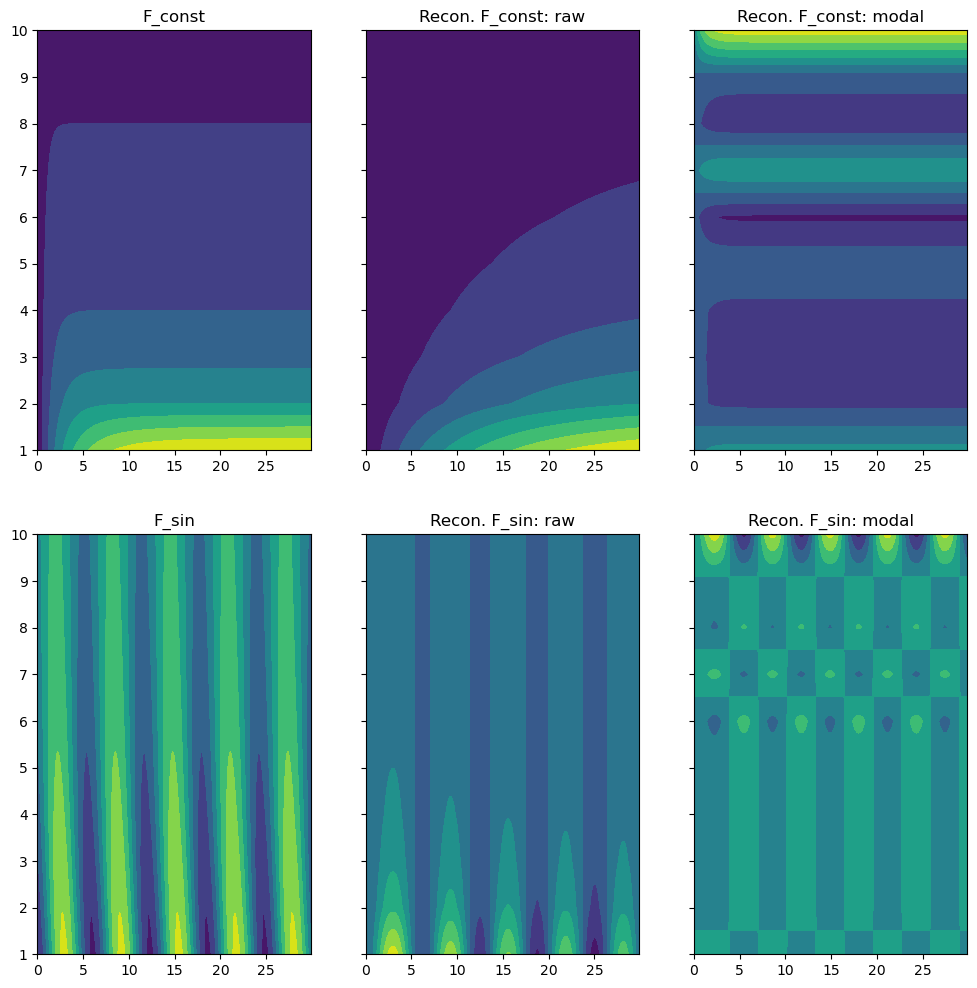

In [186]:
m = len(x)
initial_h = np.ones(m)
initial_lam = 1.0
initial_guess = np.concatenate([initial_h, [initial_lam]])
bounds = [(None, None)] * m + [(1e-10, 0.9999999999)]
options = {'disp': False}

res_raw = minimize(response_utils.opt_h_lam_2D,
              initial_guess,
              args=(T_const - T_none, F_const, t, x, dt),
              bounds=bounds,
              options=options)
res_modal = minimize(response_utils.opt_h_lam_2D,
                    initial_guess,
                    args=(a_const_sub, F_const, t, x, dt),
                    bounds=bounds,
                    options=options)

G_opt_raw = response_utils.apply_response_2D(res_raw.x, t, x)
G_opt_modal = response_utils.apply_response_2D(res_modal.x, t, x)
L2_raw, L2_modal = response_utils.plot_response_conv_2D(T_vec, F_vec, labels, t, x, G_opt_raw, G_opt_modal, g_const_sub, dt)

### Method 4: Representing G with only leading timescales (iterative minimization)

Error from raw estimation.
	L2 Error, F_const: 9.56607
	L2 Error, F_sin: 8.09359
Avg. L2 Error: 8.82983

Error from modal estimation.
	L2 Error, F_const: 40.65617
	L2 Error, F_sin: 13.6807
Avg. L2 Error: 27.16843



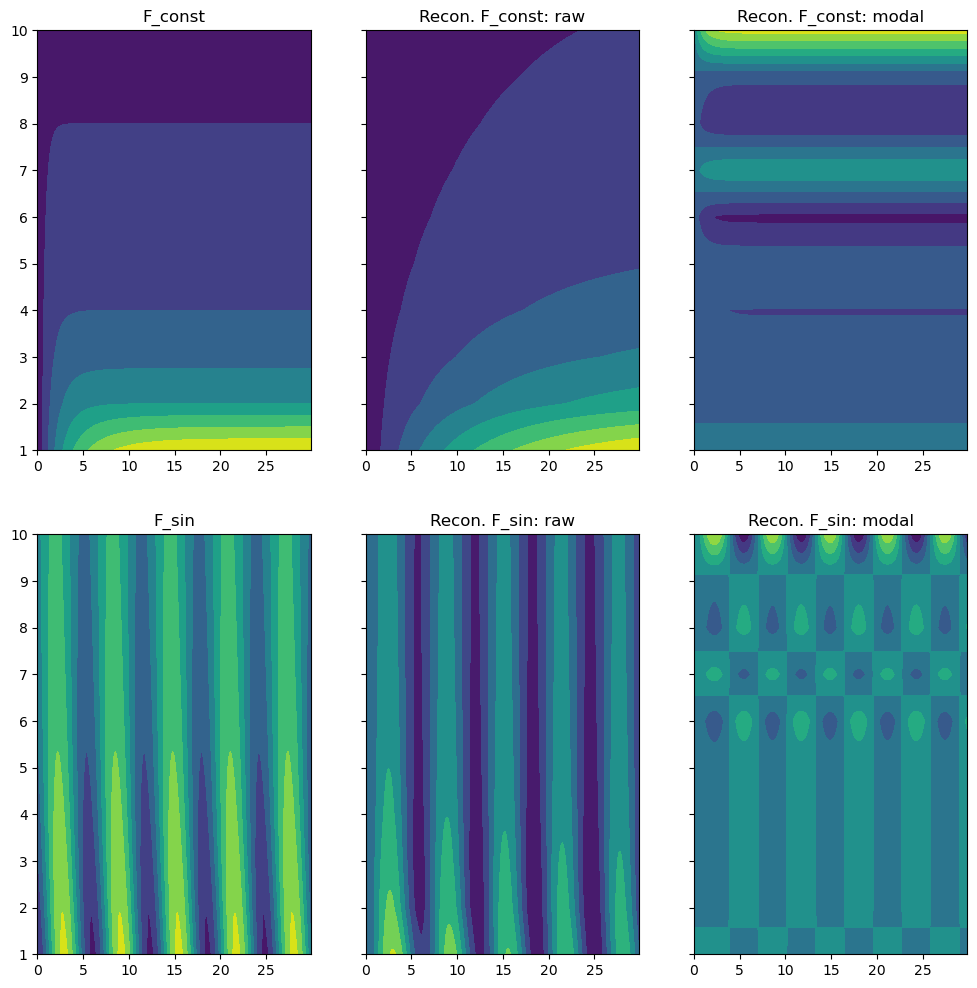

In [229]:
# Number of iterations to run
k = 3

# Run the iterative minimization
h_raw, lam_raw = response_utils.iterative_minimization(T_const - T_none, F_const, t, x, dt, k)
h_modal, lam_modal = response_utils.iterative_minimization(a_const_sub,  F_const, t, x, dt, k)

G_opt_raw = response_utils.apply_response_cumulative_2D(h_raw, lam_raw, T_const, t, x, k)
G_opt_modal = response_utils.apply_response_cumulative_2D(h_modal, lam_modal, a_const_sub, t, x, k)
L2_raw, L2_modal = response_utils.plot_response_conv_2D(T_vec, F_vec, labels, t, x, G_opt_raw, G_opt_modal, g_const_sub, dt)